In [1]:
import sys
import os
# Add the src folder to the path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [2]:
from SWIM import WaterBalanceModule
import pandas as pd

### 🔍 Climate–Discharge Modeling Workflow

This section describes the complete workflow for integrating **gridded climate datasets** with **streamflow time series** in order to train, validate, and apply **machine learning models** that predict monthly river discharge. The main objective is to evaluate the ability of climate variables to explain and forecast hydrological responses in a given watershed, using a combination of remote sensing, reanalysis datasets, and statistical learning techniques.

#### 🌍 Data Sources and Preprocessing

The analysis is based on two key types of data:

1. **Discharge Data**  
   River discharge time series are extracted from **gridded NetCDF datasets**, such as GloFAS (Global Flood Awareness System), which provide daily flow estimates across a global domain. These data are resampled to monthly means and adjusted so that all timestamps represent the first day of each month. The extraction is done at specific coordinates corresponding to pour points or monitoring stations within the basin.

2. **Climate Variables**  
   Climate predictors are retrieved from multi-variable NetCDF datasets (e.g., ERA5-Land, CMIP6, or other climate models), and typically include:
   - Total precipitation (`tp`),
   - 2-meter air temperature (`t2m`),
   - Surface solar radiation (`ssrd`),
   - Surface wind speed (`sfcWind`).

   These variables are clipped to the watershed boundaries using a shapefile, then aggregated and harmonized over time. Timestamps are normalized and spatial means are computed to generate monthly climate inputs aligned with the discharge records.

#### ⚙️ Workflow Overview

The modeling pipeline is composed of four main stages, each implemented through a dedicated function.

#### 📦 Model Outputs and Evaluation

Each model is saved with its corresponding pre-processing pipeline, allowing reproducible predictions. Additionally, visual summaries of model performance are automatically generated, including comparison plots and classification flow duration curves.

Together, this workflow facilitates a scalable and flexible framework for **data-driven water balance modeling**, suitable for both **historical calibration** and **future impact assessments** across diverse catchments and climates.


#### 1. `extract_monthly_discharge_from_netcdf`

This function extracts **monthly discharge time series** from NetCDF files (e.g., GloFAS or model output) at specified geographical coordinates. The steps include:

- Spatially selecting the grid cell closest to a target point (`method='nearest'`),
- Resampling daily discharge values to monthly means,
- Standardizing the time axis so that each monthly record starts on the first day of the month,
- Returning a clean, time-indexed `DataArray` for hydrological modeling.

In [3]:
y1,x1 = [7.134245418549412, -75.66251481454375] # Ituango Dam 
y2,x2 = [6.166183453891647, -75.60315908625327] # Medellin River (Envigado)
y3,x3 = [6.121492, -75.497809] # La Palma Watershed (Envigado)

In [4]:
swim = WaterBalanceModule()

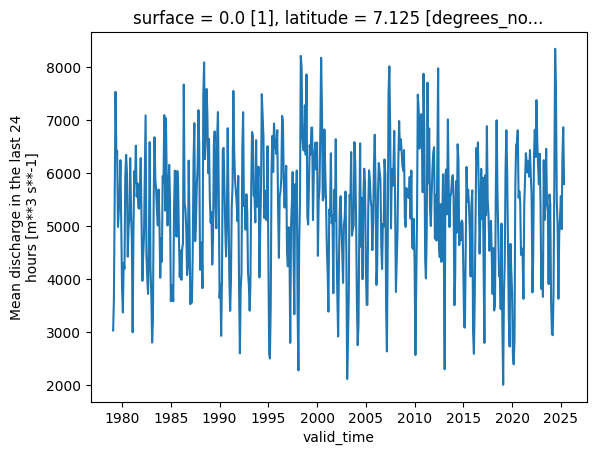

In [5]:
points = [(x1, y1), (x2, y2), (x3, y3)]
netcdf_path = '../data/discharge/discharge.nc'

discharges = swim.extract_monthly_discharge_from_netcdf(
    nc_path=netcdf_path,
    points=points,
)
# Ejemplo: acceder al primer punto
monthly_q1 = discharges['discharge_1']
monthly_q2 = discharges['discharge_2']
monthly_q3 = discharges['discharge_3']
monthly_q1.plot()

#### 2. `extract_and_plot_climate_variables`

This function processes a multi-variable NetCDF climate dataset to extract and visualize key predictors such as:

- Precipitation (`tp`),
- Temperature (`t2m`),
- Radiation (`ssrd`),
- Wind speed (`sfcWind`).

After clipping the data to the watershed polygon, the function:

- Aggregates the climate variables temporally,
- Normalizes timestamps,
- Generates spatial mean plots for each variable with overlaid basin boundaries.

This step enables both **quality control** and **exploratory analysis** before modeling.

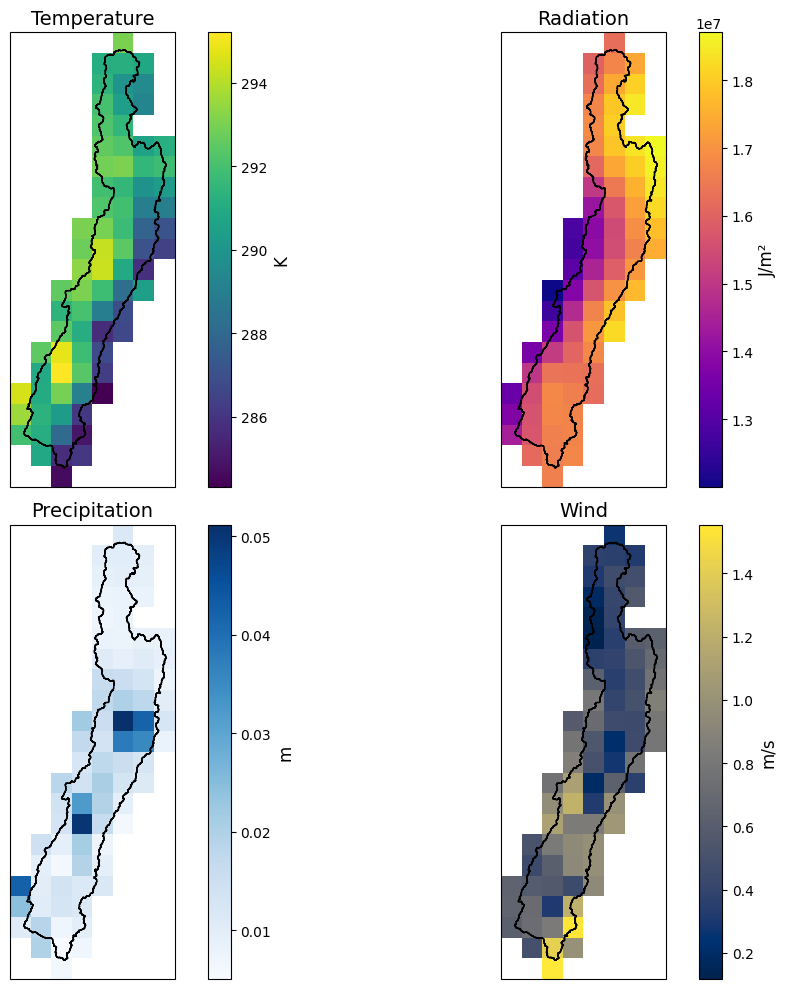

In [6]:
climate_data_1 = swim.extract_and_plot_climate_variables(
    nc_path="../data/climate/climate_data.nc",
    basin_shapefile="../data/terrain/Ituango_basin.shp",
    time_range=('1979-01-01', '2025-07-01'),
    var_mapping={
        't2m': 'Temperature',
        'ssrd': 'Radiation',
        'tp': 'Precipitation',
        'sfcWind': 'Wind'
    }
)

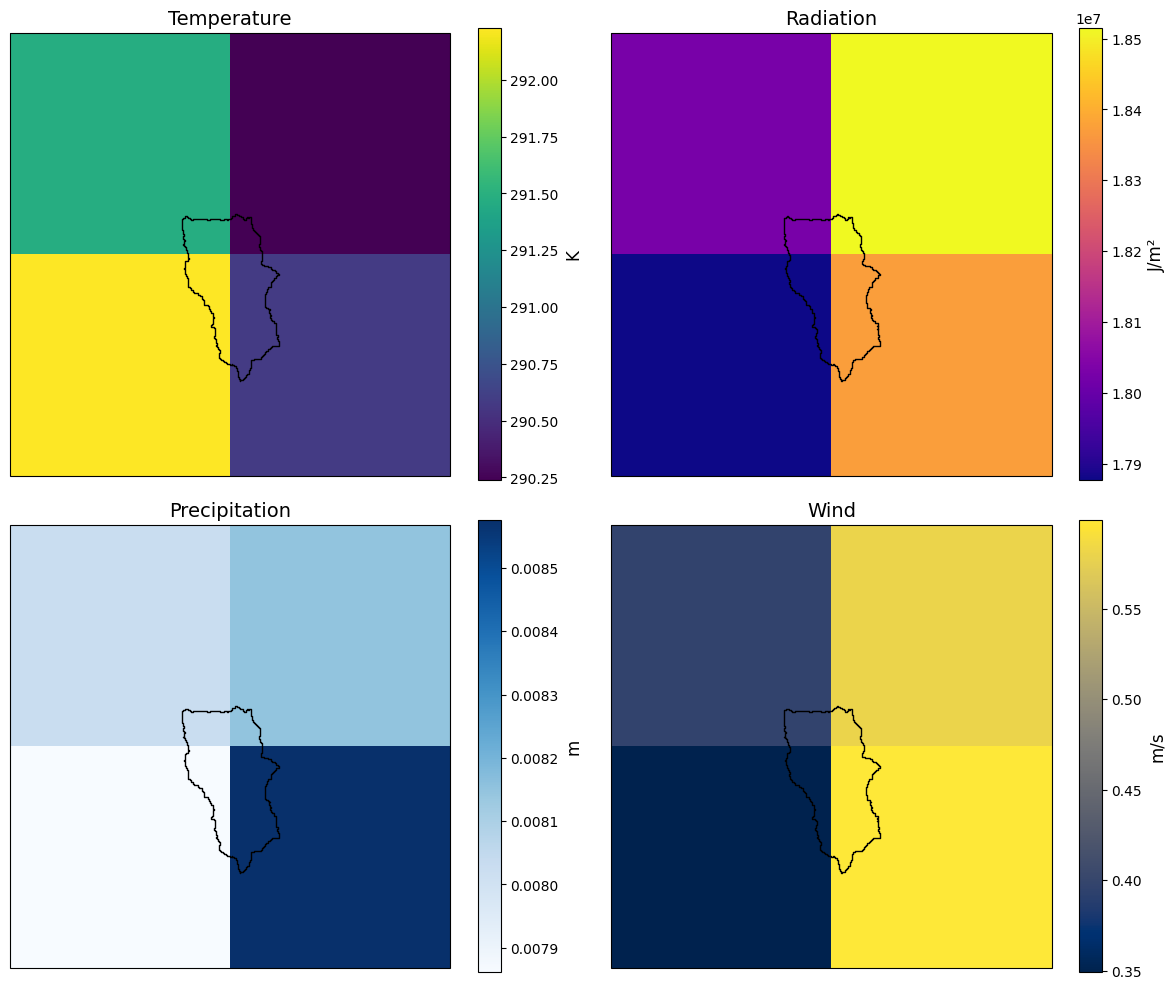

In [7]:
climate_data_2 = swim.extract_and_plot_climate_variables(
    nc_path="../data/climate/climate_data.nc",
    basin_shapefile="../data/terrain/Medellin_basin.shp",
    time_range=('1979-01-01', '2025-07-01'),
    var_mapping={
        't2m': 'Temperature',
        'ssrd': 'Radiation',
        'tp': 'Precipitation',
        'sfcWind': 'Wind'
    }
)

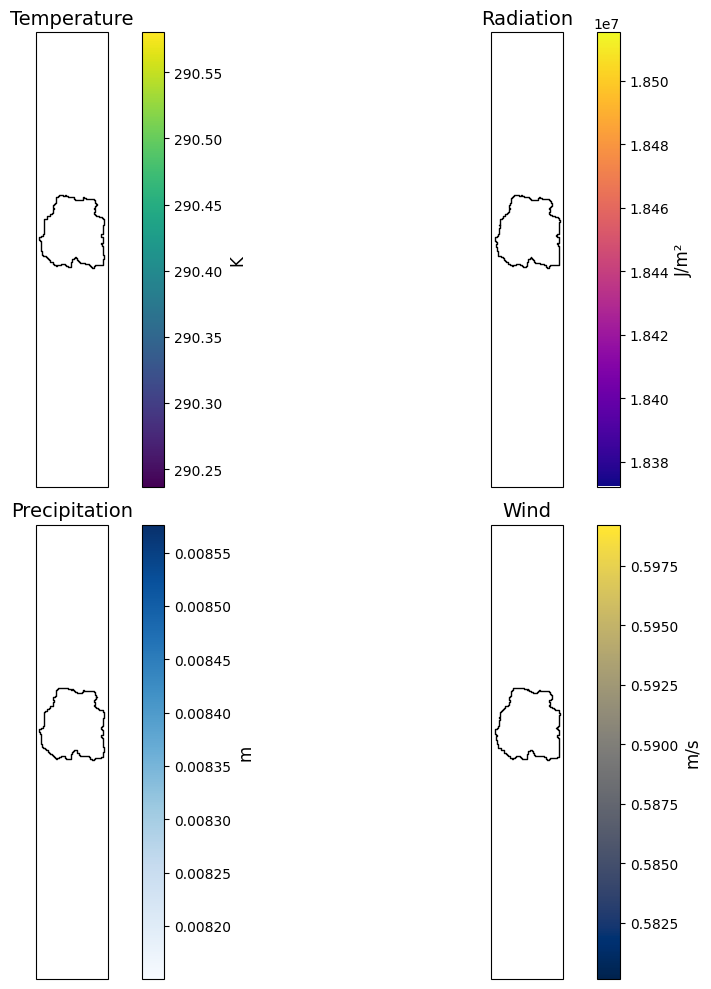

In [8]:
climate_data_3 = swim.extract_and_plot_climate_variables(
    nc_path="../data/climate/climate_data.nc",
    basin_shapefile="../data/terrain/LasPalmas_basin.shp",
    time_range=('1979-01-01', '2025-07-01'),
    var_mapping={
        't2m': 'Temperature',
        'ssrd': 'Radiation',
        'tp': 'Precipitation',
        'sfcWind': 'Wind'
    }
)

#### 3. `build_flow_models_from_climate_data`

This core function builds machine learning models (e.g., Random Forest, SVR, MLP) to simulate streamflow based on climate predictors. The process includes:

- Aligning climate variables and observed discharge by time,
- Optional dimensionality reduction via **PCA**, retaining a specified variance threshold,
- Splitting into training/testing sets,
- Performing **hyperparameter tuning** using `GridSearchCV`,
- Saving the best model and scaler objects to disk,
- Returning a performance metrics table for comparison.

This function formalizes a reproducible, data-driven approach to **simulate runoff** using historical climate information.

🔍 Training LinearRegression...
🔍 Training SVR...
🔍 Training DecisionTreeRegressor...
🔍 Training KNeighborsRegressor...
🔍 Training ElasticNet...
🔍 Training GradientBoostingRegressor...
🔍 Training AdaBoostRegressor...
🔍 Training MLPRegressor...
✅ Best model: SVR
R2       0.919898
NSE      0.911787
PBIAS   -0.395788
Name: 1, dtype: object


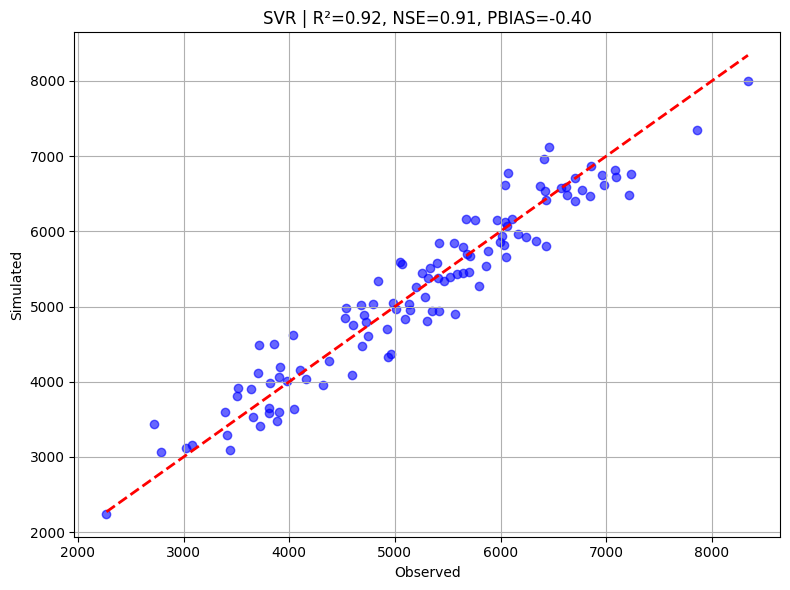

In [9]:
# Call the function with the appropriate data
best_model1, trained_model1, metrics_table1 = swim.build_flow_models_from_climate_data(
    climate_dataset=climate_data_1,
    discharge_series=monthly_q1,
    output_dir="../data/Models_1",
    predictors=['tp', 't2m', 'ssrd', 'sfcWind'],  # You can include more if available
    apply_pca=True,
    pca_var_threshold=0.95
)

🔍 Training LinearRegression...
🔍 Training SVR...
🔍 Training DecisionTreeRegressor...
🔍 Training KNeighborsRegressor...
🔍 Training ElasticNet...
🔍 Training GradientBoostingRegressor...
🔍 Training AdaBoostRegressor...
🔍 Training MLPRegressor...
✅ Best model: SVR
R2       0.697502
NSE      0.572406
PBIAS    0.049746
Name: 1, dtype: object


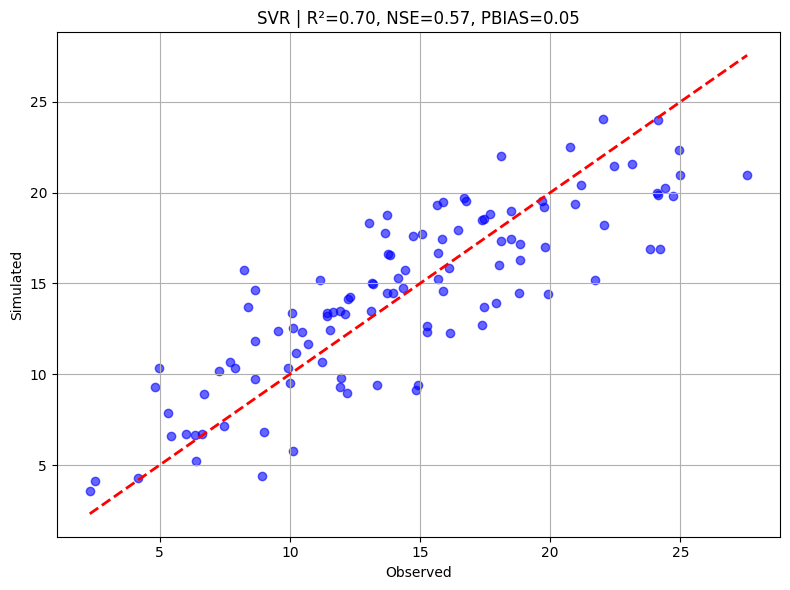

In [10]:
# Call the function with the appropriate data
best_model2, trained_model2, metrics_table2 = swim.build_flow_models_from_climate_data(
    climate_dataset=climate_data_2,
    discharge_series=monthly_q2,
    output_dir="../data/Models_2",
    predictors=['tp', 't2m', 'ssrd', 'sfcWind'],  # You can include more if available
    apply_pca=True,
    pca_var_threshold=0.95
)

🔍 Training LinearRegression...
🔍 Training SVR...
🔍 Training DecisionTreeRegressor...
🔍 Training KNeighborsRegressor...
🔍 Training ElasticNet...
🔍 Training GradientBoostingRegressor...
🔍 Training AdaBoostRegressor...
🔍 Training MLPRegressor...
✅ Best model: SVR
R2       0.614365
NSE      0.410082
PBIAS    -3.07231
Name: 1, dtype: object


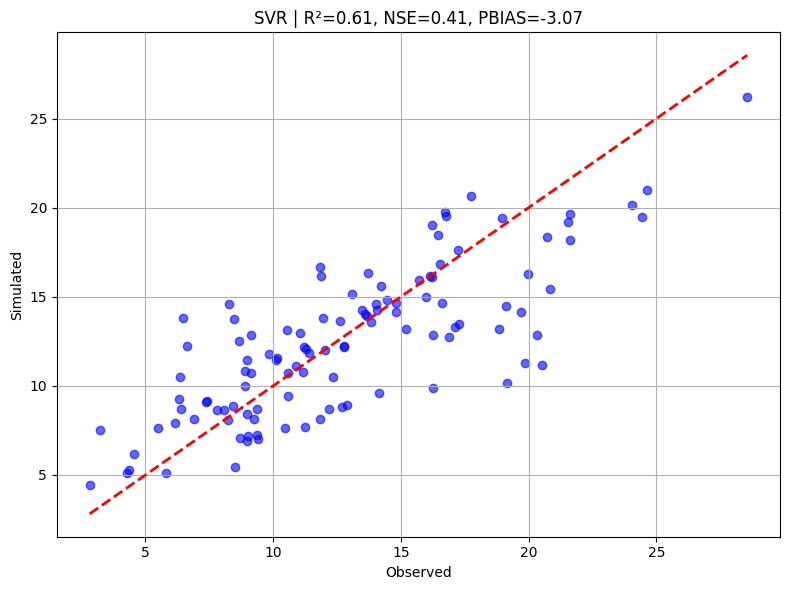

In [11]:
# Call the function with the appropriate data
best_model3, trained_model3, metrics_table3 = swim.build_flow_models_from_climate_data(
    climate_dataset=climate_data_3,
    discharge_series=monthly_q3,
    output_dir="../data/Models_3",
    predictors=['tp', 't2m', 'ssrd', 'sfcWind'],  # You can include more if available
    apply_pca=True,
    pca_var_threshold=0.95
)

#### 4. `predict_discharge_from_climate`

Once the model is trained, this function uses new climate data to generate **discharge predictions**. Key features include:

- Loading the appropriate trained model (manually specified),
- Preprocessing the new climate dataset to match the training pipeline (PCA and scaling),
- Producing monthly discharge forecasts aligned with the input time range,
- Optionally comparing predictions against observations via:
  - Time series plots,
  - Scatter plots (observed vs. predicted),
  - Cumulative discharge plots.

This prediction module is essential for **scenario-based simulations**, such as forecasting under climate change or testing model transferability.

In [12]:
observed_series_1 = pd.Series(
    monthly_q1.values,
    index=pd.to_datetime(monthly_q1.valid_time.data),
    name="Observed"
)

observed_series_2 = pd.Series(
    monthly_q2.values,
    index=pd.to_datetime(monthly_q2.valid_time.data),
    name="Observed"
)

observed_series_3 = pd.Series(
    monthly_q3.values,
    index=pd.to_datetime(monthly_q3.valid_time.data),
    name="Observed"
)

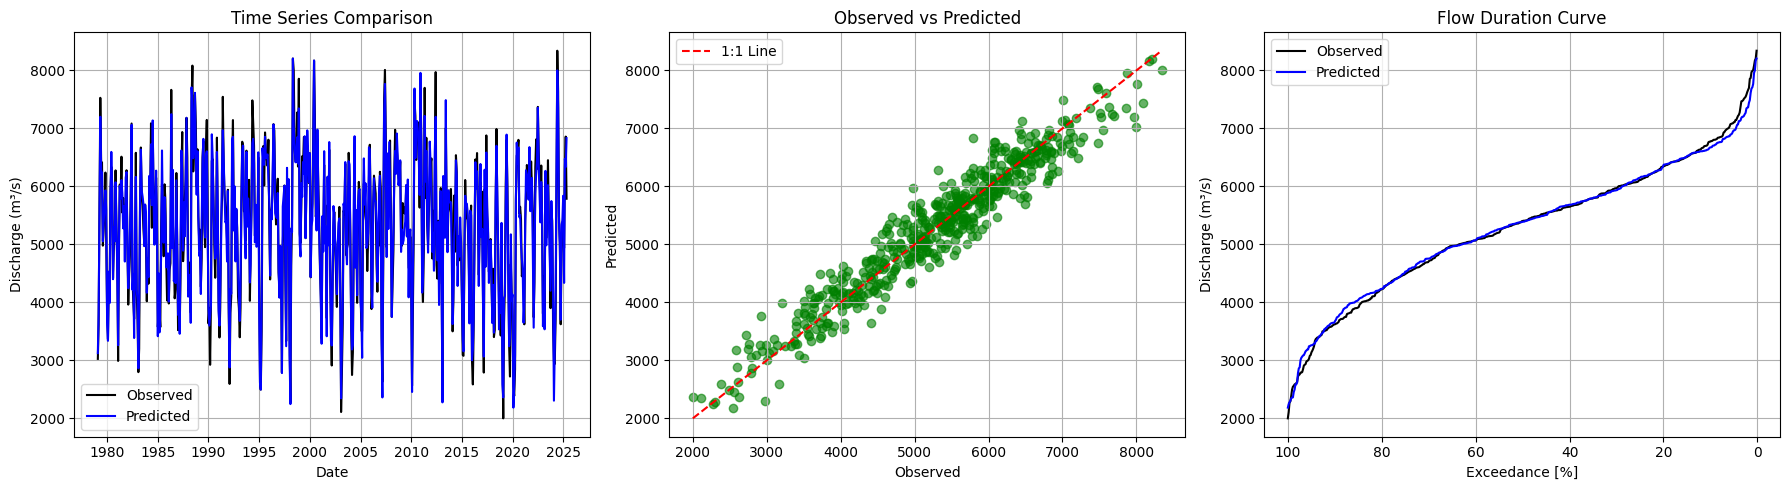

In [13]:
df_prediction_1 = swim.predict_discharge_from_climate(
    new_climate_dataset=climate_data_1,
    model_name="SVR", # Define the best model to use
    model_dir="../data/Models_1",
    predictors=["tp", "t2m", "ssrd", "sfcWind"],
    observed_series=observed_series_1
)

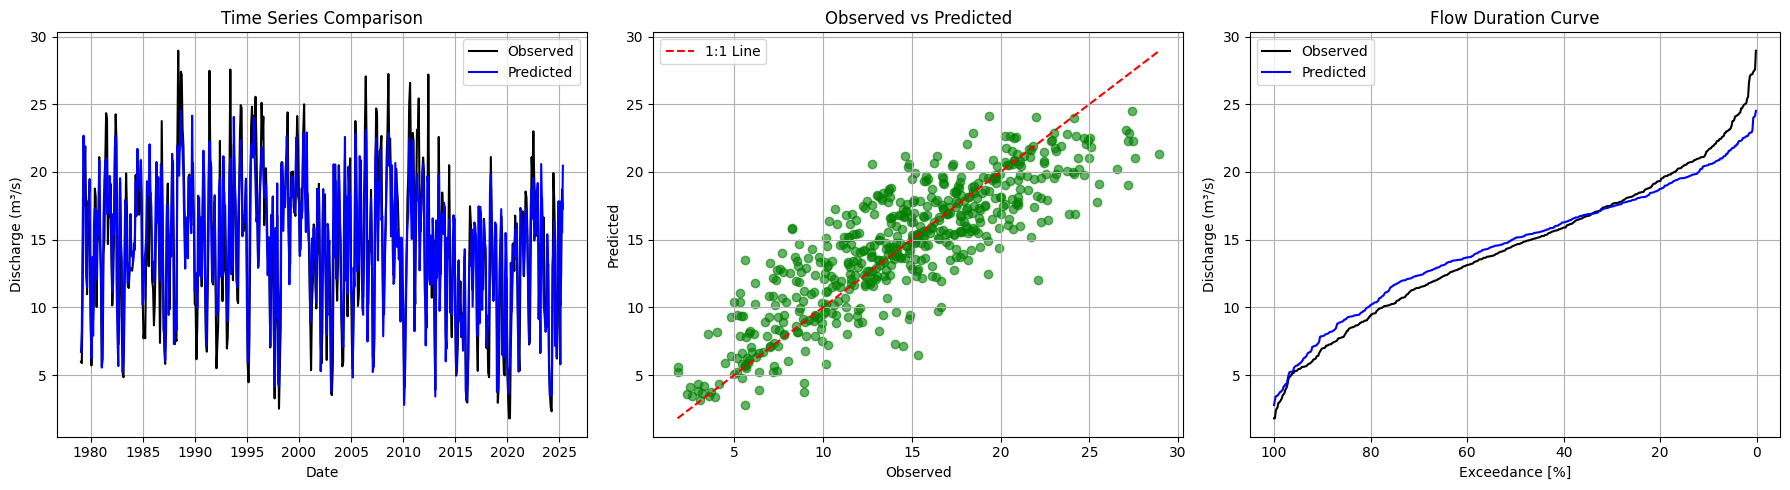

In [14]:
df_prediction_2 = swim.predict_discharge_from_climate(
    new_climate_dataset=climate_data_2,
    model_name="SVR", # Define the best model to use
    model_dir="../data/Models_2",
    predictors=["tp", "t2m", "ssrd", "sfcWind"],
    observed_series=observed_series_2
)

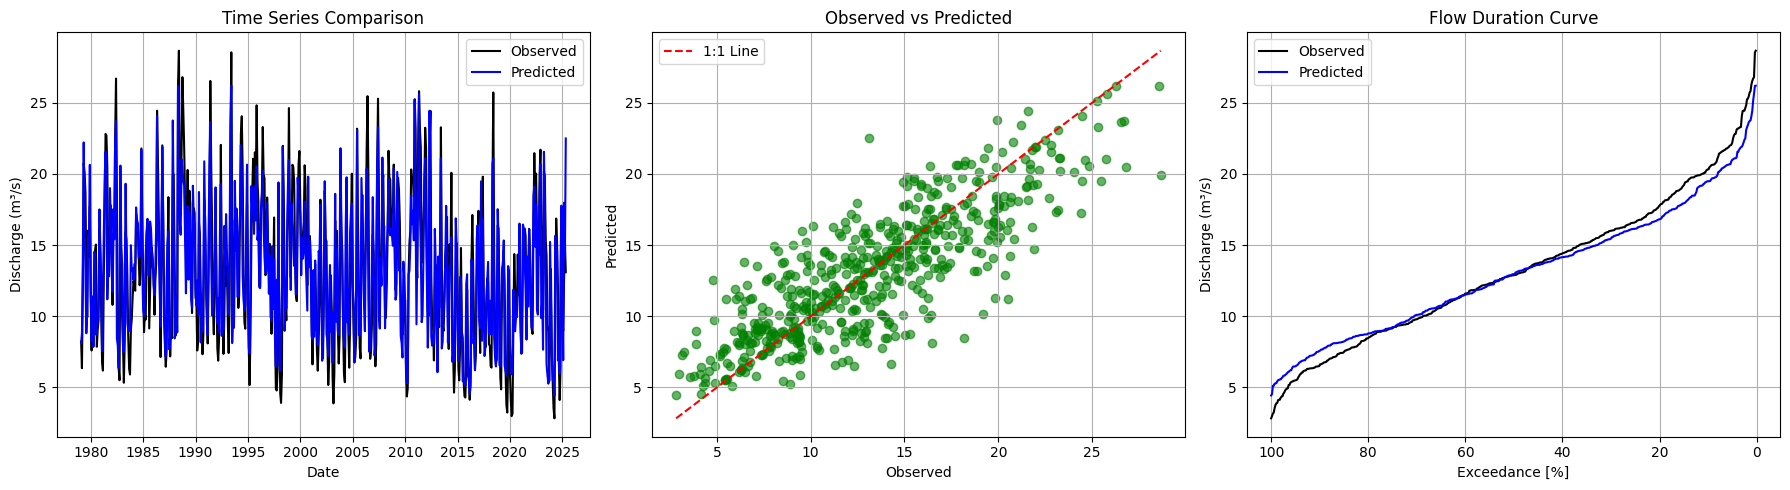

In [15]:
df_prediction_3 = swim.predict_discharge_from_climate(
    new_climate_dataset=climate_data_3,
    model_name="SVR", # Define the best model to use
    model_dir="../data/Models_3",
    predictors=["tp", "t2m", "ssrd", "sfcWind"],
    observed_series=observed_series_3
)